In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
import statsmodels.tsa.arima_model as arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
response = requests.get('https://www.quandl.com/api/v3/datasets/YAHOO/INDEX_DJI.json?api_key=HVVwXftrjiyoPyp5w-Ch')

In [3]:
response.status_code

200

In [4]:
data = response.json()

In [5]:
df = pd.DataFrame(data['dataset']['data'], columns = data['dataset']['column_names']).set_index('Date').sort_index()
df.index = pd.to_datetime(df.index, errors='raise')

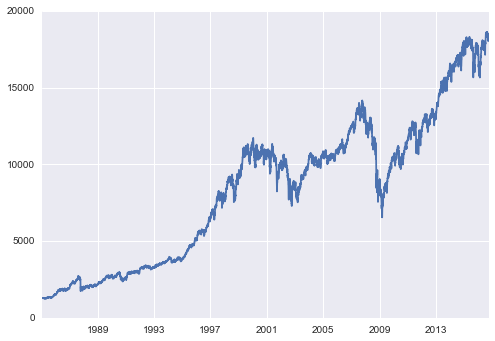

In [6]:
plt.plot(df['Close'])

In [7]:
def test_stationarity(timeseries):
    #input must be a Pandas DataFrame
    assert isinstance(timeseries, pd.Series) 
    #determining rolling stats of the timeseries
    rolling_mean = timeseries.rolling(window=365).mean()
    rolling_std = timeseries.rolling(window=365).std()
    
    #plot rolling stats
    orig = plt.plot(timeseries, color='b', label='Original')
    mean = plt.plot(rolling_mean, color='r', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Rolling Std')
    plt.show(block=False)
    
    #Perform Dickey-Fuller testing
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dftest_output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for idx, row in dftest[4].items():
        dftest_output['Critical Value ({0})'.format(idx)] = row
    print(dftest_output)

In [8]:
ts = df['Close']

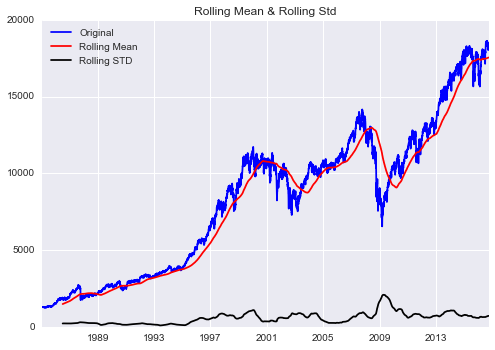

Results of Dickey-Fuller Test:


Test Statistic                    0.022089
p-value                           0.960321
#Lags Used                       34.000000
Number of Observations Used    7949.000000
Critical Value (10%)             -2.566964
Critical Value (1%)              -3.431173
Critical Value (5%)              -2.861904
dtype: float64


In [9]:
test_stationarity(ts)

# Transform

## Transform time series to natural log in base e

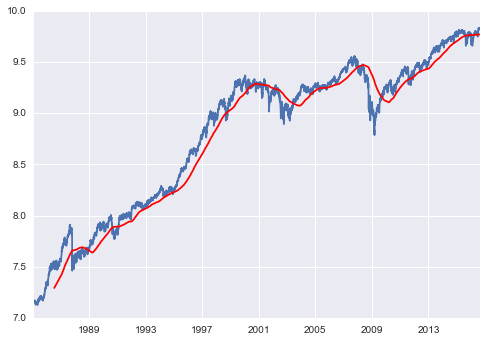

In [10]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.plot(ts_log.rolling(window=365).mean(), color='r')

In [11]:
ts_log_ma_diff = np.log(ts) - np.log(ts).rolling(window=365).mean()

In [12]:
ts_log_ma_diff.dropna(inplace=True)

## Moving Average Diff to reduce trend

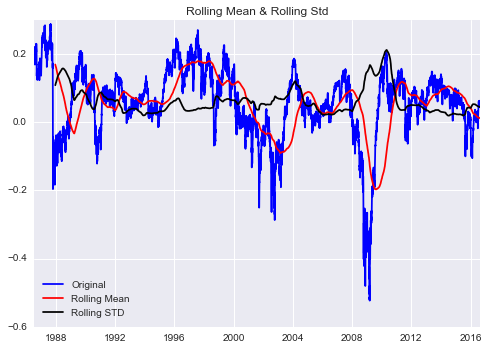

Results of Dickey-Fuller Test:


Test Statistic                   -4.288856
p-value                           0.000464
#Lags Used                       34.000000
Number of Observations Used    7566.000000
Critical Value (1%)              -3.431215
Critical Value (10%)             -2.566973
Critical Value (5%)              -2.861922
dtype: float64


In [13]:
test_stationarity(ts_log_ma_diff)

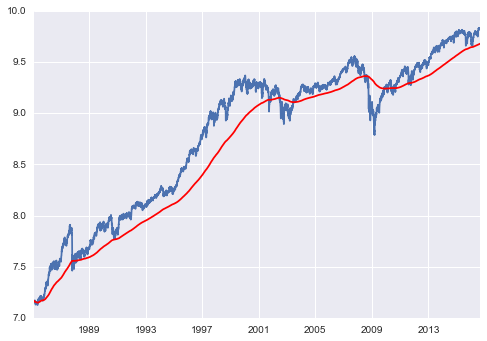

In [14]:
ewma = ts_log.ewm(halflife=365).mean()
plt.plot(ts_log)
plt.plot(ewma, color='red')

In [15]:
ts_log_ewma_diff = ts_log - ewma

## exponential weighted moving average to reduce trend without losing data at beginning

In [16]:
test_stationarity(ts_log_ewma_diff)

## Eliminating Trend and Seasonality

### Differencing

In [17]:
ts_log_diff = ts_log - ts_log.shift(365)
plt.plot(ts_log_diff)

In [189]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

# decomposition

In [18]:
decomposition = seasonal_decompose(ts_log,freq=365)

In [19]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [20]:
plt.subplot(4,1,1)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(4,1,2)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(4,1,3)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(4,1,4)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [22]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [200]:
from statsmodels.tsa.stattools import acf, pacf

In [201]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

In [203]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [204]:
from statsmodels.tsa.arima_model import ARIMA

In [205]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

In [206]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

In [207]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

# taking back to the original scale

In [209]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

In [211]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

In [212]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

In [213]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))